In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from grassfire2 import compute_skeleton, compute_segments
from tri.delaunay.helpers import ToPointsAndSegments


In [8]:
import time
from pathlib import Path
import xml.etree.ElementTree as ET
import requests

def _graphml_raw_url(url: str) -> str:
    if "github.com" in url and "/blob/" in url:
        return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    return url

def read_graphml_polygon(source: str):
    """
    Read GraphML and return a single polygon ring as [[x,y], ...].
    Accepts a local path or URL.
    """
    if source.startswith("http://") or source.startswith("https://"):
        url = _graphml_raw_url(source)
        xml_text = requests.get(url, timeout=30).text
    else:
        xml_text = Path(source).read_text(encoding="utf-8")

    root = ET.fromstring(xml_text)
    ns = {"g": "http://graphml.graphdrawing.org/xmlns"}

    key_x = None
    key_y = None
    for key in root.findall("g:key", ns):
        if key.get("attr.name") == "vertex-coordinate-x":
            key_x = key.get("id")
        elif key.get("attr.name") == "vertex-coordinate-y":
            key_y = key.get("id")

    if not key_x or not key_y:
        raise ValueError("GraphML is missing vertex-coordinate-x/y keys")

    graph = root.find("g:graph", ns)
    if graph is None:
        raise ValueError("GraphML missing <graph> element")

    nodes = graph.findall("g:node", ns)

    # If node ids are numeric, sort by integer id to preserve intended order.
    ids = [n.get("id") for n in nodes]
    if ids and all(i is not None and i.isdigit() for i in ids):
        nodes = sorted(nodes, key=lambda n: int(n.get("id")))

    ring = []
    for node in nodes:
        x = y = None
        for data in node.findall("g:data", ns):
            if data.get("key") == key_x:
                x = float(data.text)
            elif data.get("key") == key_y:
                y = float(data.text)
        if x is None or y is None:
            raise ValueError(f"Node {node.get('id')} missing x/y data")
        ring.append([x, y])

    return [ring]  # list of rings (here just one outer ring)

def plot_skeleton(poly_coords_list, title="Grassfire Straight Skeleton Demo"):
    """
    Computes and plots the straight skeleton for a list of polygon coords.
    Supports multiple rings (first ring is outer, subsequent are holes).
    Plots skeleton segments in red and their endpoints as half-opacity points.
    Returns the list of skeleton segments as returned by skel.segments().
    """
    conv = ToPointsAndSegments()

    # Add points and segments for all rings
    for ring in poly_coords_list:
        # Add points
        for p in ring:
            conv.add_point(tuple(p))

        # Add segments (closed ring)
        for i in range(len(ring)):
            start = tuple(ring[i])
            end = tuple(ring[(i + 1) % len(ring)])
            conv.add_segment(start, end)

    # Calculate the skeleton (use compute_segments if you only want the segments list)
    t0 = time.perf_counter()
    skel = compute_skeleton(conv, internal_only=True, shrink=False)  # shrink defaults to True; set shrink=False if you prefer
    t1 = time.perf_counter()
    print(f"Skeleton calculation took: {(t1 - t0) * 1000:.2f} ms")

    plt.figure(figsize=(8, 8))

    segments = skel.segments()
    print("Number of skeleton segments:", len(segments))

    # Draw skeleton segments
    for segment in segments:
        (start_pt, end_pt), infos = segment
        plt.plot([start_pt[0], end_pt[0]], [start_pt[1], end_pt[1]], color="r", linewidth=1, zorder=2)

    # Plot segment endpoints as half-opacity points (deduplicate)
    endpoint_set = set()
    for segment in segments:
        (start_pt, end_pt), _ = segment
        endpoint_set.add((float(start_pt[0]), float(start_pt[1])))
        endpoint_set.add((float(end_pt[0]), float(end_pt[1])))

    if endpoint_set:
        xs = [p[0] for p in endpoint_set]
        ys = [p[1] for p in endpoint_set]
        plt.scatter(xs, ys, c='r', s=20, alpha=0.5, marker='o', zorder=3)

    # Plot original polygon rings
    for i, ring in enumerate(poly_coords_list):
        x_poly = [p[0] for p in ring] + [ring[0][0]]
        y_poly = [p[1] for p in ring] + [ring[0][1]]
        label = "Outer Boundary" if i == 0 else f"Hole {i}"
        fmt = "b-" if i == 0 else "g-"
        plt.plot(x_poly, y_poly, fmt, label=label, linewidth=2, zorder=1)

    # prepare legend entries
    plt.plot([], [], 'r--', label='Grassfire Skeleton')

    plt.axis('equal')
    plt.xticks([])  # Hide x axis values
    plt.yticks([])  # Hide y axis values

    # Position legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    plt.title(title)
    plt.gca().invert_yaxis()  # if your coordinates are pixel-like, invert; remove if not needed
    plt.show()

    return segments

Skeleton calculation took: 66.33 ms
Number of skeleton segments: 555


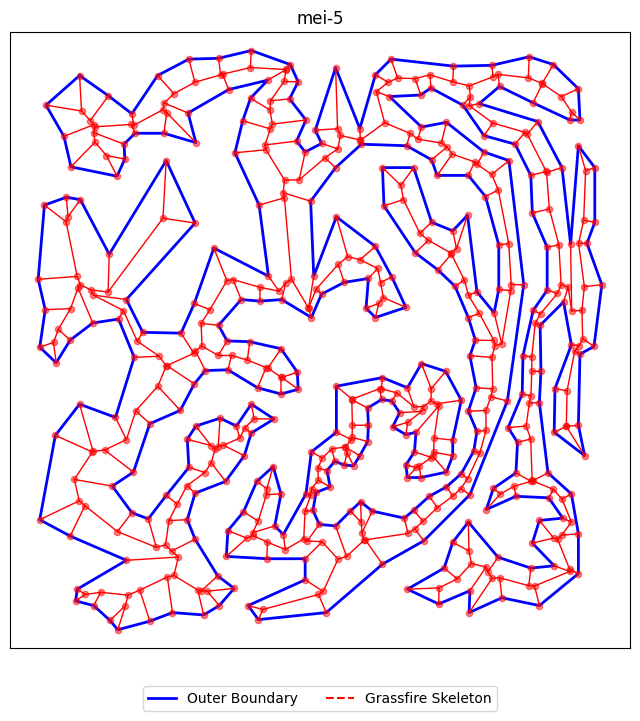

In [15]:
poly = "mei-5"
url = f"https://raw.githubusercontent.com/LingDong-/interesting-polygon-archive/master/json/{poly}.json"
eberly_coords = requests.get(url).json()

segs = plot_skeleton(eberly_coords, f"{poly}")